In [1]:
import imutils
import numpy as np
import cv2
from matplotlib import pyplot as plt

class Stitcher:
	def stitch(self, images, ratio=0.75, reprojThresh=4.0, showMatches=False):
		# 检测关键点，获取局部不变描述符
		(imageB, imageA) = images
		(kpsA, featuresA) = self.detectAndDescribe(imageA)
		(kpsB, featuresB) = self.detectAndDescribe(imageB)

		# 匹配特征
		Keypoints = self.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)

		# 图像拼接
		(matches, H, status) = Keypoints
		result = cv2.warpPerspective(imageA, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
		direct=result.copy()
		direct[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

		# 融合图像
		rows,cols=imageB.shape[:2]
		for col in range(0,cols):
			if imageB[:, col].any() and result[:, col].any():  # 开始重叠的最左端
				left = col
				break
		for col in range(cols-1, 0, -1):
			if imageB[:, col].any() and result[:, col].any():  # 重叠的最右一列
				right = col
				break
		res = np.zeros([rows, cols, 3], np.uint8)
		for row in range(0, rows):
			for col in range(0, cols):
				if not imageB[row, col].any():  # 没有原图，用旋转的填充
					res[row, col] = result[row, col]
				elif not result[row, col].any():
					res[row, col] = imageB[row, col]
				else:
					srcImgLen = float(abs(col - left))
					testImgLen = float(abs(col - right))
					alpha = srcImgLen / (srcImgLen + testImgLen)
					res[row, col] = np.clip(imageB[row, col] * (1-alpha) + result[row, col] * alpha, 0, 255)

		result[0:imageB.shape[0], 0:imageB.shape[1]]=res

		if showMatches:
			vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
			return (result, direct, vis)

		return result


	# 使用高斯差分DoG关键点检测，和SIFT特征提取
	def detectAndDescribe(self, image):
		# 检测图片中的关键点
		sift = cv2.xfeatures2d.SIFT_create()
		(kps, features) = sift.detectAndCompute(image, None)
		kps = np.float32([kp.pt for kp in kps])

		return (kps, features)


	def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
		# 计算原始匹配并初始化实际的匹配
		matcher = cv2.DescriptorMatcher_create("BruteForce")
		rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
		matches = []

		# David Lowe’s ratio来做修剪
		for rawMatch in rawMatches:
			if len(rawMatch) == 2 and rawMatch[0].distance < rawMatch[1].distance * ratio:
				matches.append((rawMatch[0].trainIdx, rawMatch[0].queryIdx))

		if len(matches) > 4:
			ptsA = np.float32([kpsA[i] for (_, i) in matches])
			ptsB = np.float32([kpsB[i] for (i, _) in matches])

			# 计算两组点之间的变换矩阵
			(H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)

			return (matches, H, status)

		# 匹配的点小于4个,不能计算变换矩阵
		return None


	# 输出的可视化图像
	def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
		(high_A, width_A) = imageA.shape[:2]
		(high_B, width_B) = imageB.shape[:2]
		vis = np.zeros((max(high_A, high_B), width_A + width_B, 3), dtype="uint8") 
		vis[0:high_A, 0:width_A] = imageA
		vis[0:high_B, width_A:] = imageB

		for ((trainIdx, queryIdx), s) in zip(matches, status):
			if s == 1:
				# 画出匹配关系
				ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
				ptB = (int(kpsB[trainIdx][0]) + width_A, int(kpsB[trainIdx][1]))
				cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

		return vis

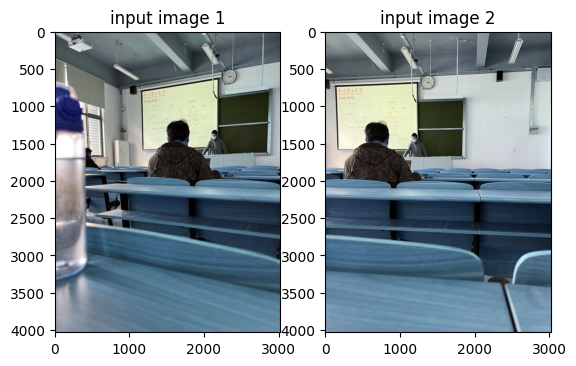

In [2]:
# 读取图像并修改大小，加快速度
imageA = cv2.imread('1.jpg')
imageB = cv2.imread('2.jpg')

fig, axes = plt.subplots(nrows=1, ncols=2)

# 在子图中显示图片
axes[0].imshow(imageA)
axes[1].imshow(imageB)

# 设置图像标题
axes[0].set_title('input image 1')
axes[1].set_title('input image 2')

# 显示图片
plt.show()

imageA = imutils.resize(imageA, width=400)
imageB = imutils.resize(imageB, width=400)

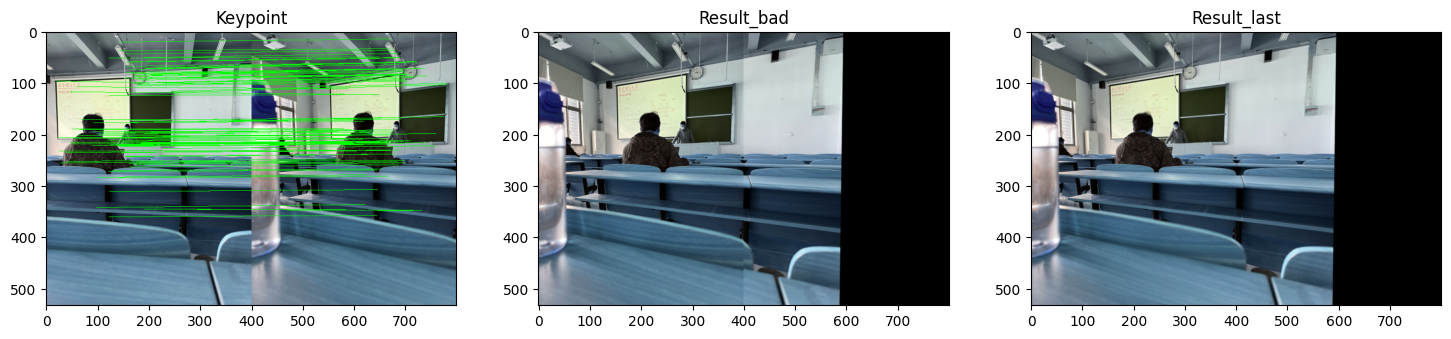

In [3]:
stitcher = Stitcher()
(result, direct, vis) = stitcher.stitch([imageA, imageB], showMatches=True)

# 保存图像并显示
cv2.imwrite("Keypoint.jpg", vis)
cv2.imwrite("Result_bad.jpg", direct)
cv2.imwrite("Result.jpg", result)

# 创建子图
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# 在子图中显示图片
axes[0].imshow(vis)
axes[1].imshow(direct)
axes[2].imshow(result)

# 设置图像标题
axes[0].set_title('Keypoint')
axes[1].set_title('Result_bad')
axes[2].set_title('Result_last')

plt.show()